# Optimization

The quantum fidelity of a quantum gate, as calculated in the simulation, can
be used as figure of merit in an optimization algorithm in order to find a
control pulse that implements a quantum gate with minimal infidelity.

Let us repeat the previous setup code:


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qopt.matrix import DenseOperator
from qopt.solver_algorithms import SchroedingerSolver
from qopt.cost_functions import OperationInfidelity


sigma_x = DenseOperator.pauli_x()
sigma_y = DenseOperator.pauli_y()
sigma_z = DenseOperator.pauli_z()
zero_matrix = DenseOperator(np.zeros((2, 2)))

delta_omega = 0

h_ctrl = [.5 * sigma_x, .5 * sigma_y]
h_drift = [delta_omega * .5 * sigma_z]

n_time_steps = 5
total_time = 1

time_steps = (total_time / n_time_steps) * np.ones((n_time_steps, ))

control_amplitudes = np.zeros((n_time_steps, len(h_ctrl)))
control_amplitudes[:, 0] = np.pi

solver = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=time_steps
)
solver.set_optimization_parameters(0 * control_amplitudes)

entanglement_infidelity = OperationInfidelity(
    solver=solver,
    target=sigma_x
)

The Simulator class defines an interface between the simulation and the
optimization algorithm. This facilitates the replacement of the optimization
algorithm by the user.

The simulator class can handle multiple solver instances to evaluate a system
with different noise descriptions for the same control pulse. The cost
functions may include the effects caused by multiple noise sources.

In [2]:
from qopt.simulator import Simulator

simulator = Simulator(
    solvers=[solver, ],
    cost_funcs=[entanglement_infidelity, ]
)

The actual optimization algorithm is controlled by the class Optimizer. We
use the least squares optimization of scipy.

In [3]:
from qopt.optimize import LeastSquaresOptimizer

termination_conditions = {
    "min_gradient_norm": 1e-15,
    "min_cost_gain": 1e-15,
    "max_wall_time": 30.0,
    "max_cost_func_calls": 1e6,
    "max_iterations": 100,
    "min_amplitude_change": 1e-8
}

upper_bounds = 2 * np.pi * np.ones((len(h_ctrl) * n_time_steps, ))
lower_bounds = -1 * upper_bounds

optimizer = LeastSquaresOptimizer(
    system_simulator=simulator,
    termination_cond=termination_conditions,
    save_intermediary_steps=True,
    bounds=[lower_bounds, upper_bounds]
)

The bounds mark the range in which the optimization algorithm shall search for
an optimum. As initial values, we use a random pulse.

In [4]:
initial_pulse = np.pi * np.random.rand(n_time_steps, len(h_ctrl))

result = optimizer.run_optimization(initial_control_amplitudes=initial_pulse)

Next we initialize a data container to store the information gained in the
optimization. The DataContainer class is instantiated with a storage path
and file name, where the data can be stored.


In [5]:
from qopt.data_container import DataContainer
from qopt.analyser import Analyser

data_container = DataContainer(
    storage_path=r'..\..\..\temp',
    file_name="File Name"
)

data_container.append_optim_result(optim_result=result)
analyser = Analyser(data=data_container)

The data container class is used to gather the information of multiple
optimization runs and can be used to write data to and load it from the hard
drive.

The Analyser gives access to some convenience functions to plot the cost
function evaluations during the optimization run.


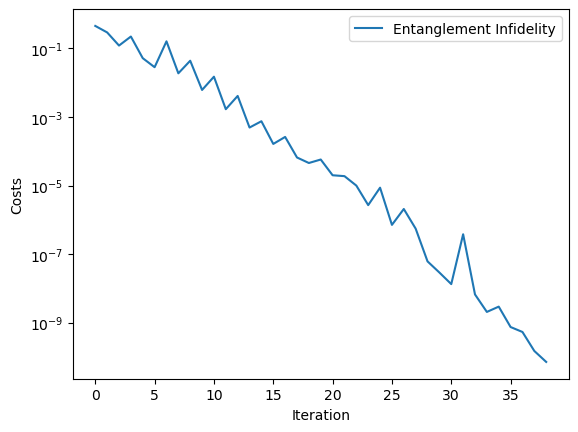

In [6]:
analyser.plot_costs()
plt.show()

In the plotted costs, we can observe the expected linear convergence for
newton-like optimization algorithms.

The Data container allows also to pickle the gathered data for later analysis.


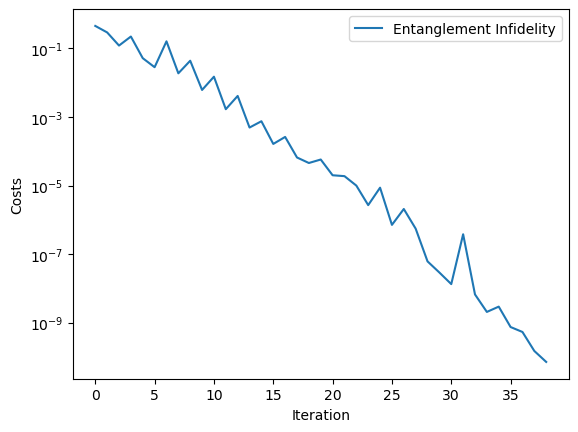

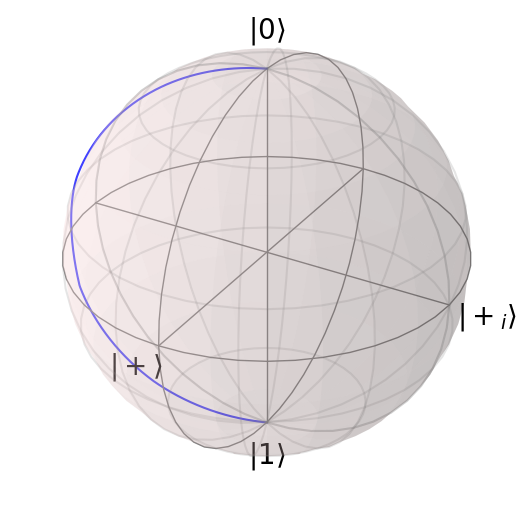

In [7]:
data_container.to_pickle()
loaded_data = DataContainer.from_pickle(r'..\..\..\temp\File Name')

analyser = Analyser(loaded_data)
analyser.plot_costs()
solver.set_optimization_parameters(loaded_data.final_parameters[0])
solver.plot_bloch_sphere()
plt.show()